# cassava leaf disease categorization using deep neural network 

In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
#!pip install tensorflow-gpu

In [63]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 40

### Import data into tensorflow dataset object

In [64]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2587 files belonging to 5 classes.


In [65]:
#This will show the classes names that exists
class_names = dataset.class_names
class_names

['CBB', 'CBSD', 'CGM', 'CMD', 'HEALTHY']

In [66]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 128, 128, 3)
[1 1 3 2 2 3 2 3 4 1 3 0 1 1 4 1 4 3 2 4 2 1 3 3 2 0 0 3 3 4 1 1]


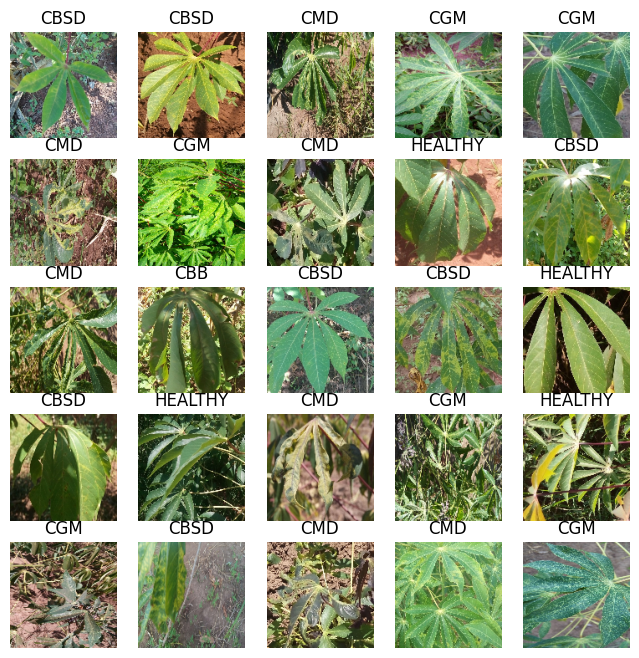

In [67]:
plt.figure(figsize=(8,8))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    #ploting images
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #plt.scatter(image_batch[i], class_names[labels_batch[i]], c='blue')
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [68]:
names = []
s = []
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch.shape)
    print(labels_batch.numpy())
 
    for i in range(32):
        data = pd.DataFrame(labels_batch)
        names = class_names[labels_batch[i]]
        s.append(names)
        print(s[i])
 

       

[3 3 1 0 3 1 3 3 1 4 1 1 2 2 2 3 1 4 0 4 1 3 1 1 2 3 2 3 3 1 2 4]
CMD
CMD
CBSD
CBB
CMD
CBSD
CMD
CMD
CBSD
HEALTHY
CBSD
CBSD
CGM
CGM
CGM
CMD
CBSD
HEALTHY
CBB
HEALTHY
CBSD
CMD
CBSD
CBSD
CGM
CMD
CGM
CMD
CMD
CBSD
CGM
HEALTHY


In [69]:
len(s)

32

In [70]:
len(data)

32

In [71]:
data['names'] = s

In [72]:
data

,0,names
0,3,CMD
1,3,CMD
2,1,CBSD
3,0,CBB
4,3,CMD
5,1,CBSD
6,3,CMD
7,3,CMD
8,1,CBSD
9,4,HEALTHY


In [73]:
data.rename(columns={0:'id'}, inplace = True)

In [74]:
data.head()


,id,names
0,3,CMD
1,3,CMD
2,1,CBSD
3,0,CBB
4,3,CMD


In [75]:
import numpy as np
np.unique(data['id'])

array([0, 1, 2, 3, 4])

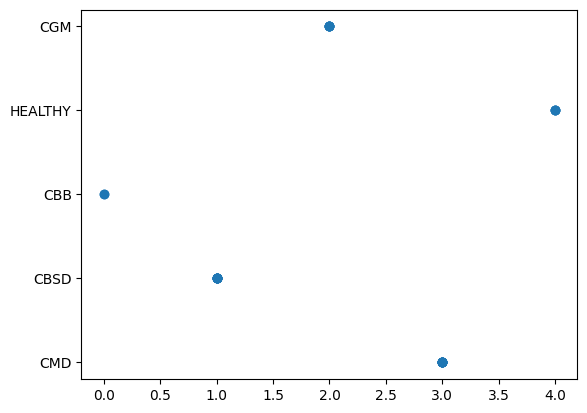

In [76]:
plt.scatter(data.id, data.names)

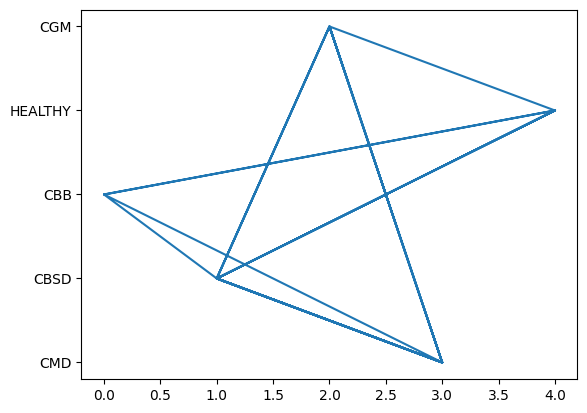

In [77]:
plt.plot(data.id, data.names)

In [78]:
len(dataset)

81

In [79]:
train_size = 0.8
len(dataset)*train_size

64.8

In [80]:
train_ds = dataset.take(20)
len(train_ds)

20

In [81]:
test_ds = dataset.skip(20)
len(test_ds)

61

In [82]:
val_size=0.1
len(dataset)*val_size

8.1

In [83]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [84]:
test_ds = test_ds.skip(2)
len(test_ds)

59

## Partitioning Data 

In [85]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [86]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [87]:
len(train_ds)

64

In [88]:
len(val_ds)

8

In [89]:
len(test_ds)

9

In [90]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [91]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [92]:
'''data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])'''

'data_augmentation = tf.keras.Sequential([\n  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),\n  layers.experimental.preprocessing.RandomRotation(0.2),\n])'

In [93]:
'''train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
'''

'train_ds = train_ds.map(\n    lambda x, y: (data_augmentation(x, training=True), y)\n).prefetch(buffer_size=tf.data.AUTOTUNE)\n'

## Building the Model

In [94]:
input__shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input__shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input__shape)

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 63, 63, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 30, 30, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (32, 28, 28, 64)         

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [97]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,)

Epoch 1/40
64/64 [==============================] - 60s 859ms/step - loss: 1.5569 - accuracy: 0.3003 - val_loss: 1.5723 - val_accuracy: 0.3555
Epoch 2/40
64/64 [==============================] - 49s 772ms/step - loss: 1.4791 - accuracy: 0.3638 - val_loss: 1.4605 - val_accuracy: 0.4336
Epoch 3/40
64/64 [==============================] - 50s 789ms/step - loss: 1.3874 - accuracy: 0.4287 - val_loss: 1.4055 - val_accuracy: 0.4375
Epoch 4/40
64/64 [==============================] - 49s 761ms/step - loss: 1.3592 - accuracy: 0.4399 - val_loss: 1.3913 - val_accuracy: 0.4414
Epoch 5/40
64/64 [==============================] - 50s 789ms/step - loss: 1.3136 - accuracy: 0.4648 - val_loss: 1.2627 - val_accuracy: 0.4688
Epoch 6/40
64/64 [==============================] - 50s 780ms/step - loss: 1.2643 - accuracy: 0.4893 - val_loss: 1.2703 - val_accuracy: 0.4609
Epoch 7/40
64/64 [==============================] - 50s 787ms/step - loss: 1.2485 - accuracy: 0.4980 - val_loss: 1.2618 - val_accuracy: 0.4844

## visualization of loss and accuracy

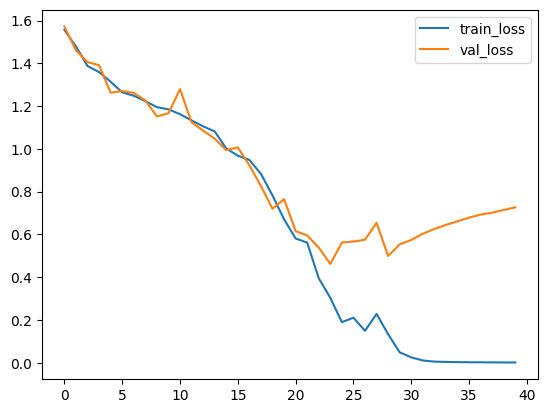

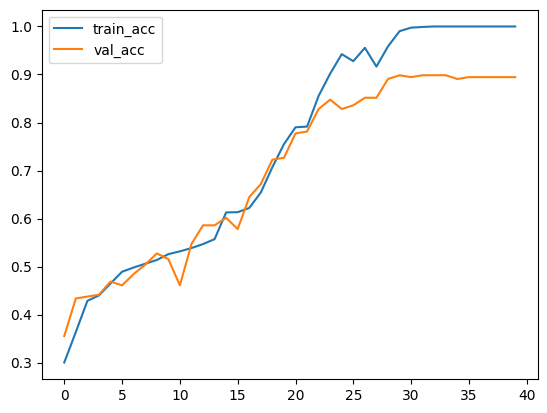

In [98]:

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [99]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 231ms/step - loss: 0.7933 - accuracy: 0.9201


In [100]:
scores

[0.7932556867599487, 0.9201388955116272]

In [101]:
y_pred = model.predict(test_ds)

9/9 [==============================] - 2s 231ms/step


In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

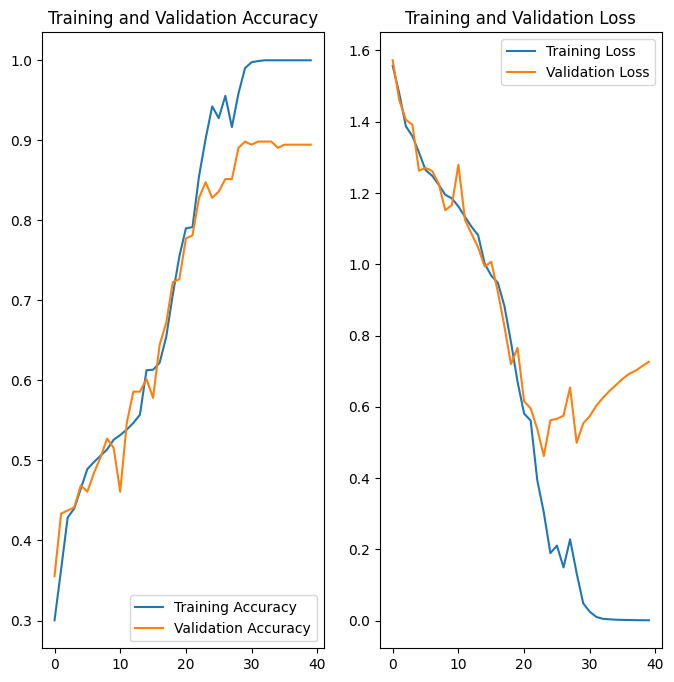

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction of some data

first image to predict
actual label: CBB
1/1 [==============================] - 0s 347ms/step
3
predicted label: CMD


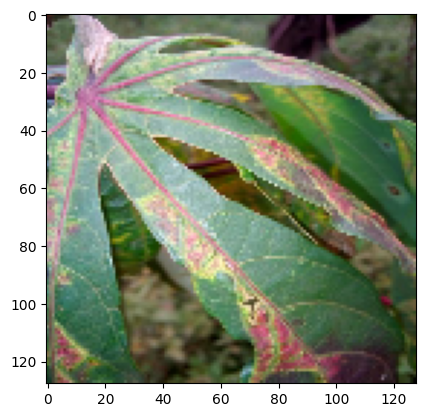

In [104]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [105]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


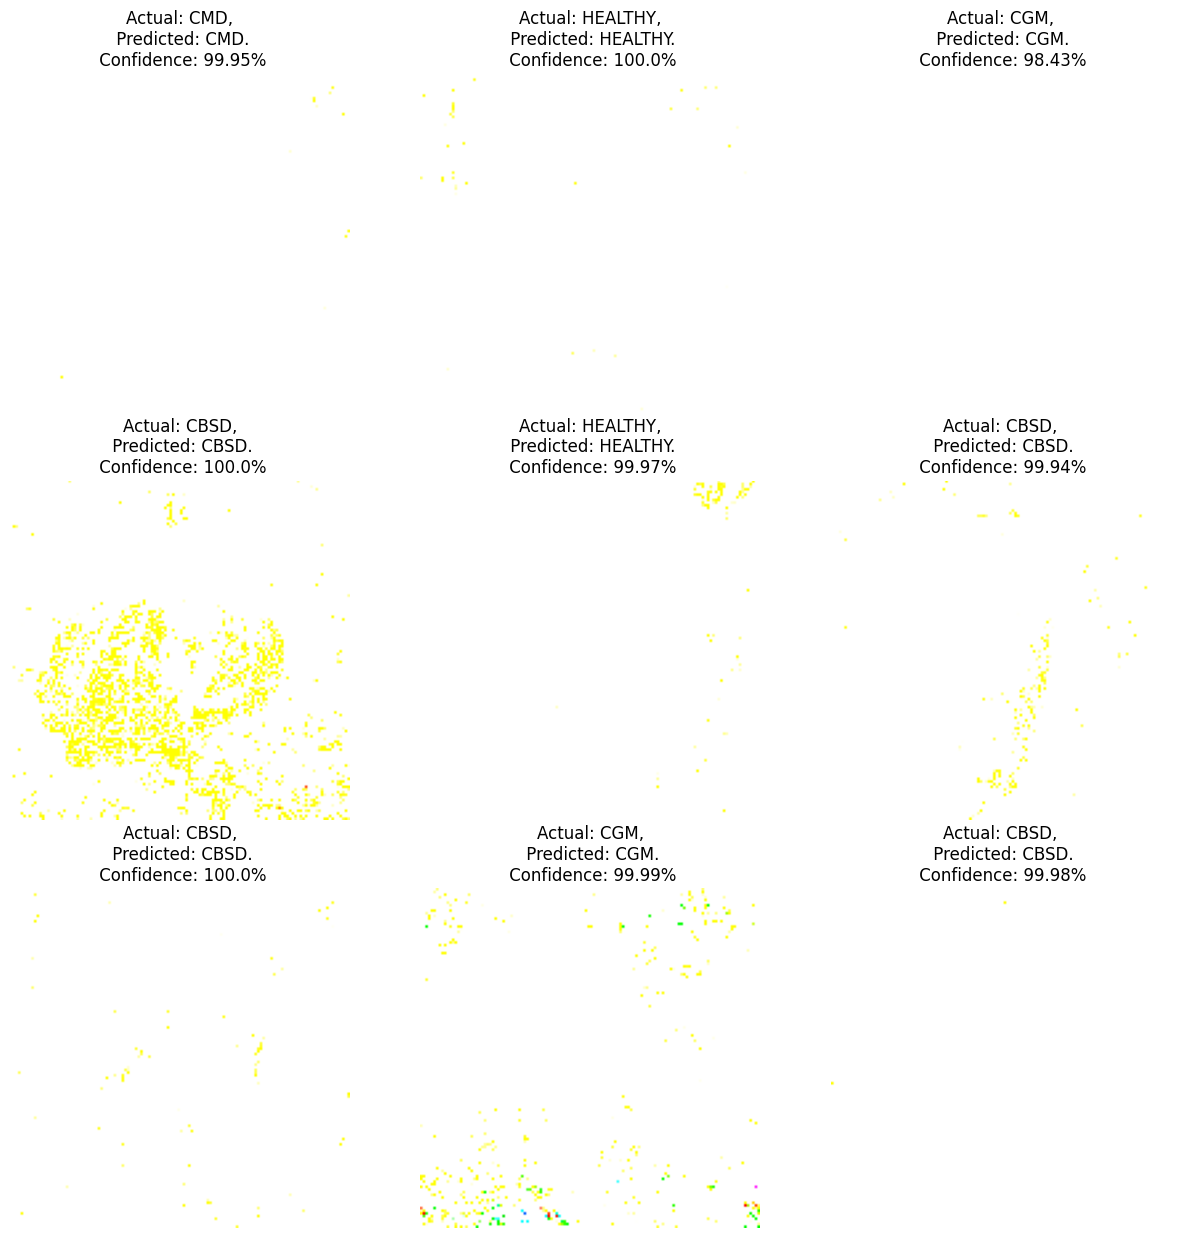

In [106]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [107]:
model.save("cassava_output.h5")

In [108]:
###################################

In [109]:
####VGG16 restnet

In [110]:
'''from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt'''

'from keras.layers import Input, Lambda, Dense, Flatten\nfrom keras.models import Model\nfrom keras.applications.vgg16 import VGG16\nfrom keras.applications.vgg16 import preprocess_input\nfrom keras.preprocessing import image\nfrom keras.preprocessing.image import ImageDataGenerator\nfrom keras.models import Sequential\nimport numpy as np\nfrom glob import glob\nimport matplotlib.pyplot as plt'

In [111]:
'''# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/train')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)'''



"# add preprocessing layer to the front of VGG\nvgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)\n\n# don't train existing weights\nfor layer in vgg.layers:\n  layer.trainable = False\n  \n\n  \n  # useful for getting number of classes\nfolders = glob('/content/drive/MyDrive/train')\n  \n\n# our layers - you can add more if you want\nx = Flatten()(vgg.output)\n# x = Dense(1000, activation='relu')(x)\nprediction = Dense(len(folders), activation='softmax')(x)\n\n# create a model object\nmodel = Model(inputs=vgg.input, outputs=prediction)\n\n# view the structure of the model\nmodel.summary()\n\n# tell the model what cost and optimization method to use\nmodel.compile(\n  loss='categorical_crossentropy',\n  optimizer='adam',\n  metrics=['accuracy']\n)"

In [112]:

'''from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/train',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''

"from keras.preprocessing.image import ImageDataGenerator\n\ntrain_datagen = ImageDataGenerator(rescale = 1./255,\n                                   shear_range = 0.2,\n                                   zoom_range = 0.2,\n                                   horizontal_flip = True)\n\ntest_datagen = ImageDataGenerator(rescale = 1./255)\n\ntraining_set = train_datagen.flow_from_directory('/content/drive/MyDrive/train',\n                                                 target_size = (224, 224),\n                                                 batch_size = 32,\n                                                 class_mode = 'categorical')\n\ntest_set = test_datagen.flow_from_directory('/content/drive/MyDrive/train',\n                                            target_size = (224, 224),\n                                            batch_size = 32,\n                                            class_mode = 'categorical')\n\n"

In [113]:
'''# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
'''

'# fit the model\nr = model.fit(\n  training_set,\n  validation_data=test_set,\n  epochs=5,\n  steps_per_epoch=len(training_set),\n  validation_steps=len(test_set)\n)\n'

In [114]:
'''# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')'''

"# loss\nplt.plot(r.history['loss'], label='train loss')\nplt.plot(r.history['val_loss'], label='val loss')\nplt.legend()\nplt.show()\nplt.savefig('LossVal_loss')\n\n# accuracies\nplt.plot(r.history['acc'], label='train acc')\nplt.plot(r.history['val_acc'], label='val acc')\nplt.legend()\nplt.show()\nplt.savefig('AccVal_acc')"